In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import storage
import nltk
from nltk.tokenize import RegexpTokenizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import layers
from keras import Model
from keras import Sequential
from keras import Input

import functions_14 as fn

%matplotlib inline

Using TensorFlow backend.


# Use multiple features for ML model

## First prep the feature data

In [2]:
# Load data
BUCKET_NAME = 'salary-data'
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)
df_train = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'data_location_buckets.csv'))

In [3]:
#df_train.columns

In [4]:
df_sub = df_train[['Title', 'FullDescription','ContractType', 'ContractTime', 'Company',
       'Category', 'TTWA_County','SalaryNormalized']]
df_sub.ContractType = df_sub.ContractType.fillna('Missing')
df_sub.ContractTime = df_sub.ContractTime.fillna('Missing')
df_sub.Company = df_sub.Company.fillna('Missing')
# Drop other NaN values
df_sub = df_sub.dropna()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## NLP of Description

In [6]:
X_words = fn.first_NLP(df_sub)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_words)
word_dictionary = tokenizer.word_index
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
X_words_seq = tokenizer.texts_to_sequences(X_words)

lengths = []
for x in X_words_seq:
    lengths.append(len(x))
max_length = max(lengths)

X_words_padded = tf.keras.preprocessing.sequence.pad_sequences(X_words_seq,maxlen=max_length, padding='post')

In [7]:
X_words_padded.shape

(195896, 1267)

## Hot encode features

In [32]:
def hot_encode(df_variable):
    enc = OneHotEncoder()
    X = df_variable.values
    X = enc.fit_transform(X.reshape(-1, 1))
    return X

In [33]:
X_location = hot_encode(df_sub.TTWA_County)
X_contract_type = hot_encode(df_sub.ContractType)
X_contract_time = hot_encode(df_sub.ContractTime)
X_category = hot_encode(df_sub.Category) 
X_company = hot_encode(df_sub.Company) # Too big

In [57]:
# Concatenate location, contract, and category
from scipy.sparse import hstack
X_one_hot = hstack((X_location,X_contract_type,X_contract_time,X_category))


In [59]:
X_location = X_one_hot

## Create train/test split

In [60]:
y = df_sub.SalaryNormalized

In [61]:
X_train_full, X_test_words, y_train_full, y_test = train_test_split( X_words_padded, y, test_size=0.2, random_state=42)

X_train_words, X_val_words, y_train, y_val = train_test_split( X_train_full, y_train_full, test_size=0.2, random_state=42)

In [62]:
X_train_full, X_test_location, y_train_full, y_test = train_test_split( X_location, y, test_size=0.2, random_state=42)

X_train_location, X_val_location, y_train, y_val = train_test_split( X_train_full, y_train_full, test_size=0.2, random_state=42)

## Build model with only 1-Hot-Enocded variables as input

In [68]:
input_ = Input(shape=(X_train_location.shape[1]),)
x = Dense(100, activation='relu')(input_)
x = Dense(1, activation='linear')(x)
x = Model(inputs=input_,outputs = x)
x.compile(loss = 'mean_squared_error', optimizer = 'Adam')

In [70]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
epochs = 10
batch_size = 8
history = x.fit(X_train_location.todense(), y_train, epochs =epochs, batch_size = batch_size, verbose = 1, 
                validation_data = (X_val_location.todense(), y_val),
                callbacks = es)

Epoch 1/10
15672/15672 [==============================] - 42s 3ms/step - loss: 646924928.0000 - val_loss: 256936592.0000
Epoch 2/10
15672/15672 [==============================] - 41s 3ms/step - loss: 241159120.0000 - val_loss: 238564672.0000
Epoch 3/10
15672/15672 [==============================] - 43s 3ms/step - loss: 230370512.0000 - val_loss: 233237264.0000
Epoch 4/10
15672/15672 [==============================] - 40s 3ms/step - loss: 227201600.0000 - val_loss: 231653840.0000
Epoch 5/10
15672/15672 [==============================] - 41s 3ms/step - loss: 226091728.0000 - val_loss: 231028368.0000
Epoch 6/10
15672/15672 [==============================] - 41s 3ms/step - loss: 225570544.0000 - val_loss: 230734784.0000
Epoch 7/10
15672/15672 [==============================] - 40s 3ms/step - loss: 225267936.0000 - val_loss: 230559072.0000
Epoch 8/10
15672/15672 [==============================] - 43s 3ms/step - loss: 225089856.0000 - val_loss: 230482288.0000
Epoch 9/10
15672/15672 [========

In [71]:
loss = x.evaluate(X_test_location.todense(), y_test,verbose =1)
y_mean = np.mean(y_train)
rmse_mean = round(np.sqrt(np.mean((y_test-y_mean)**2)))
print("Mean RMSE = {}".format(rmse_mean))
print("Model RMSE = {}".format(round(np.sqrt(loss))))

1225/1225 [==============================] - 3s 3ms/step - loss: 224581488.0000
Mean RMSE = 17252
Model RMSE = 14986


In [73]:
y_pred = x.predict(X_test_location.todense(),verbose = 1)

1225/1225 [==============================] - 2s 1ms/step


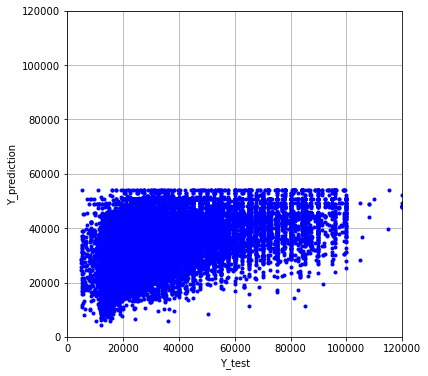

In [74]:
limits= [0,120000]
fig = plt.figure(figsize = (6,6))  
ax = fig.add_subplot(1, 1, 1)  
ax.plot(y_test, y_pred, 'b.')
ax.set_ylabel('Y_prediction')
ax.set_xlabel('Y_test')
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.grid()
plt.show()

## Build functional Model with multiple inputs

In [75]:
from keras.layers import Embedding, Flatten, concatenate

In [76]:
Input_embed = Input(shape = (X_train_words.shape[1],))
Input_location = Input(shape = (X_train_location.shape[1],))

# First build the Embedding branch

x = Embedding(size_of_vocabulary, 25,  input_length=max_length)(Input_embed)
x = Conv1D(filters=100, kernel_size=5, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(30, activation = 'relu')(x)
x = Model(inputs = Input_embed, outputs = x)

# Build the location branch

y = Dense(10, activation='relu')(Input_location)
y = Dense(1, activation='linear')(y)
y = Model(inputs = Input_location, outputs = y)

# Combine the models

combined = concatenate([x.output, y.output])

z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)

model = Model(inputs=[x.input, y.input], outputs=z)

## Train model

In [78]:
model.compile(loss="mean_squared_error", optimizer='Adam')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model.fit(
    [X_train_words, X_train_location.todense()], y_train,
    validation_data=([X_val_words, X_val_location.todense()], y_val),
    epochs=10, batch_size=8, callbacks = es)

Epoch 1/10
15672/15672 [==============================] - 1475s 94ms/step - loss: 137031680.0000 - val_loss: 118550656.0000
Epoch 2/10
15672/15672 [==============================] - 1457s 93ms/step - loss: 108801288.0000 - val_loss: 110897168.0000
Epoch 3/10
15672/15672 [==============================] - 1486s 95ms/step - loss: 100001184.0000 - val_loss: 109426776.0000
Epoch 4/10
15672/15672 [==============================] - 1461s 93ms/step - loss: 93649440.0000 - val_loss: 106974416.0000
Epoch 5/10
15672/15672 [==============================] - 1440s 92ms/step - loss: 84613016.0000 - val_loss: 100612032.0000
Epoch 6/10
15672/15672 [==============================] - 1438s 92ms/step - loss: 74081752.0000 - val_loss: 100293760.0000
Epoch 7/10
15672/15672 [==============================] - 1468s 94ms/step - loss: 64810848.0000 - val_loss: 97657840.0000
Epoch 8/10
15672/15672 [==============================] - 1435s 92ms/step - loss: 57147244.0000 - val_loss: 96135896.0000
Epoch 9/10
1567

## Evaluate model

In [24]:
loss = model.evaluate([X_test_words, X_test_location.todense()], y_test,verbose =1)

1225/1225 [==============================] - 85s 69ms/step - loss: 112264888.0000


In [25]:
y_mean = np.mean(y_train)
rmse_mean = round(np.sqrt(np.mean((y_test-y_mean)**2)))
print("Mean RMSE = {}".format(rmse_mean))
print("Model RMSE = {}".format(round(np.sqrt(loss))))

Mean RMSE = 17252
Model RMSE = 10596


In [26]:
y_pred = model.predict([X_test_words, X_test_location.todense()],verbose = 1)

1225/1225 [==============================] - 85s 69ms/step


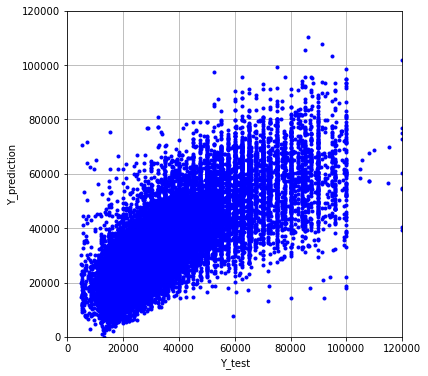

In [27]:
limits= [0,120000]
fig = plt.figure(figsize = (6,6))  
ax = fig.add_subplot(1, 1, 1)  
ax.plot(y_test, y_pred, 'b.')
ax.set_ylabel('Y_prediction')
ax.set_xlabel('Y_test')
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.grid()
plt.show()